# Laboratorium

### Konfiguracja

In [10]:
# Narzędzie jest oparte o kilka zewnętrznych bibliotek, które potrzebujemy najpierw zaimportować.
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
from matplotlib.widgets import Button
import json as js

# Parametr określający jak blisko (w odsetku całego widocznego zakresu) punktu początkowego 
# wielokąta musimy kliknąć, aby go zamknąć.
TOLERANCE = 0.15

def dist(point1, point2):
    return np.sqrt(np.power(point1[0] - point2[0], 2) + np.power(point1[1] - point2[1], 2))

# Klasa ta trzyma obecny stan wykresu oraz posiada metody, które mają zostać wykonane
# po naciśnięciu przycisków.
class _Button_callback(object):
    def __init__(self, scenes):
        self.i = 0
        self.scenes = scenes
        self.adding_points = False
        self.added_points = []
        self.adding_lines = False
        self.added_lines = []
        self.adding_rects = False
        self.added_rects = []

    def set_axes(self, ax):
        self.ax = ax
        
    # Metoda ta obsługuje logikę przejścia do następnej sceny.
    def next(self, event):
        self.i = (self.i + 1) % len(self.scenes)
        self.draw(autoscaling = True)

    # Metoda ta obsługuje logikę powrotu do poprzedniej sceny.
    def prev(self, event):
        self.i = (self.i - 1) % len(self.scenes)
        self.draw(autoscaling = True)
        
    # Metoda ta aktywuje funkcję rysowania punktów wyłączając równocześnie rysowanie 
    # odcinków i wielokątów.
    def add_point(self, event):
        self.adding_points = not self.adding_points
        self.new_line_point = None
        if self.adding_points:
            self.adding_lines = False
            self.adding_rects = False
            self.added_points.append(PointsCollection([]))
            
    # Metoda ta aktywuje funkcję rysowania odcinków wyłączając równocześnie
    # rysowanie punktów i wielokątów.     
    def add_line(self, event):   
        self.adding_lines = not self.adding_lines
        self.new_line_point = None
        if self.adding_lines:
            self.adding_points = False
            self.adding_rects = False
            self.added_lines.append(LinesCollection([]))

    # Metoda ta aktywuje funkcję rysowania wielokątów wyłączając równocześnie
    # rysowanie punktów i odcinków.
    def add_rect(self, event):
        self.adding_rects = not self.adding_rects
        self.new_line_point = None
        if self.adding_rects:
            self.adding_points = False
            self.adding_lines = False
            self.new_rect()
    
    def new_rect(self):
        self.added_rects.append(LinesCollection([]))
        self.rect_points = []
        
    # Metoda odpowiedzialna za właściwą logikę rysowania nowych elementów. W
    # zależności od włączonego trybu dodaje nowe punkty, początek, koniec odcinka
    # lub poszczególne wierzchołki wielokąta. Istnieje ciekawa logika sprawdzania
    # czy dany punkt jest domykający dla danego wielokąta. Polega ona na tym, że
    # sprawdzamy czy odległość nowego punktu od początkowego jest większa od
    # średniej długości zakresu pomnożonej razy parametr TOLERANCE.   
    def on_click(self, event):
        if event.inaxes != self.ax:
            return
        new_point = (event.xdata, event.ydata)
        if self.adding_points:
            self.added_points[-1].add_points([new_point])
            self.draw(autoscaling = False)
        elif self.adding_lines:
            if self.new_line_point is not None:
                self.added_lines[-1].add([self.new_line_point, new_point])
                self.new_line_point = None
                self.draw(autoscaling = False)
            else:
                self.new_line_point = new_point
        elif self.adding_rects:
            if len(self.rect_points) == 0:
                self.rect_points.append(new_point)
            elif len(self.rect_points) == 1:
                self.added_rects[-1].add([self.rect_points[-1], new_point])
                self.rect_points.append(new_point)
                self.draw(autoscaling = False)
            elif len(self.rect_points) > 1:
                if dist(self.rect_points[0], new_point) < (np.mean([self.ax.get_xlim(), self.ax.get_ylim()])*TOLERANCE):
                    self.added_rects[-1].add([self.rect_points[-1], self.rect_points[0]])
                    self.new_rect()
                else:    
                    self.added_rects[-1].add([self.rect_points[-1], new_point])
                    self.rect_points.append(new_point)
                self.draw(autoscaling = False)
    
    # Metoda odpowiedzialna za narysowanie całego wykresu. Warto zauważyć,
    # że zaczyna się ona od wyczyszczenia jego wcześniejszego stanu. Istnieje w
    # niej nietrywialna logika zarządzania zakresem wykresu, tak żeby, w zależności
    # od ustawionego parametru autoscaling, uniknąć sytuacji, kiedy dodawanie
    # nowych punktów przy brzegu obecnie widzianego zakresu powoduje niekorzystne
    # przeskalowanie.
    def draw(self, autoscaling = True):
        if not autoscaling:
            xlim = self.ax.get_xlim()
            ylim = self.ax.get_ylim()
        self.ax.clear()
        for collection in (self.scenes[self.i].points + self.added_points):
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), **collection.kwargs)
        for collection in (self.scenes[self.i].lines + self.added_lines + self.added_rects):
            self.ax.add_collection(collection.get_collection())
        self.ax.autoscale(autoscaling)
        if not autoscaling:
            self.ax.set_xlim(xlim)
            self.ax.set_ylim(ylim)
        plt.draw()


### Interfejsy

[Dostępne kolory](https://matplotlib.org/3.1.1/gallery/color/named_colors.html)

[Dostępne znaczniki punktów](https://matplotlib.org/3.1.1/api/markers_api.html#module-matplotlib.markers)

In [11]:
# Klasa Scene odpowiada za przechowywanie elementów, które mają być
# wyświetlane równocześnie. Konkretnie jest to lista PointsCollection i
# LinesCollection.
class Scene:
    def __init__(self, points=[], lines=[]):
        self.points=points
        self.lines=lines

# Klasa PointsCollection gromadzi w sobie punkty jednego typu, a więc takie,
# które zostaną narysowane w takim samym kolorze i stylu. W konstruktorze
# przyjmuje listę punktów rozumianych jako pary współrzędnych (x, y). Parametr
# kwargs jest przekazywany do wywołania funkcji z biblioteki MatPlotLib przez
# co użytkownik może podawać wszystkie parametry tam zaproponowane.        
class PointsCollection:
    def __init__(self, points, **kwargs):
        self.points = points
        self.kwargs = kwargs
    
    def add_points(self, points):
        self.points = self.points + points

# Klasa LinesCollection podobnie jak jej punktowy odpowiednik gromadzi
# odcinki tego samego typu. Tworząc ją należy podać listę linii, gdzie każda
# z nich jest dwuelementową listą punktów – par (x, y). Parametr kwargs jest
# przekazywany do wywołania funkcji z biblioteki MatPlotLib przez co użytkownik
# może podawać wszystkie parametry tam zaproponowane.
class LinesCollection:
    def __init__(self, lines, **kwargs):
        self.lines = lines
        self.kwargs = kwargs
        
    def add(self, line):
        self.lines.append(line)
        
    def get_collection(self):
        return mcoll.LineCollection(self.lines, **self.kwargs)

# Klasa Plot jest najważniejszą klasą w całym programie, ponieważ agreguje
# wszystkie przygotowane sceny, odpowiada za stworzenie wykresu i przechowuje
# referencje na przyciski, dzięki czemu nie będą one skasowane podczas tzw.
# garbage collectingu.
class Plot:
    def __init__(self, scenes = [Scene()], points = [], lines = [], json = None):
        if json is None:
            self.scenes = scenes
            if points or lines:
                self.scenes[0].points = points
                self.scenes[0].lines = lines
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]], 
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]]) 
                           for scene in js.loads(json)]
    
    # Ta metoda ma szczególne znaczenie, ponieważ konfiguruje przyciski i
    # wykonuje tym samym dość skomplikowaną logikę. Zauważmy, że konfigurując każdy
    # przycisk podajemy referencję na metodę obiektu _Button_callback, która
    # zostanie wykonana w momencie naciśnięcia.
    def __configure_buttons(self):
        plt.subplots_adjust(bottom=0.2)
        ax_prev = plt.axes([0.6, 0.05, 0.15, 0.075])
        ax_next = plt.axes([0.76, 0.05, 0.15, 0.075])
        ax_add_point = plt.axes([0.44, 0.05, 0.15, 0.075])
        ax_add_line = plt.axes([0.28, 0.05, 0.15, 0.075])
        ax_add_rect = plt.axes([0.12, 0.05, 0.15, 0.075])
        b_next = Button(ax_next, 'Następny')
        b_next.on_clicked(self.callback.next)
        b_prev = Button(ax_prev, 'Poprzedni')
        b_prev.on_clicked(self.callback.prev)
        b_add_point = Button(ax_add_point, 'Dodaj punkt')
        b_add_point.on_clicked(self.callback.add_point)
        b_add_line = Button(ax_add_line, 'Dodaj linię')
        b_add_line.on_clicked(self.callback.add_line)
        b_add_rect = Button(ax_add_rect, 'Dodaj figurę')
        b_add_rect.on_clicked(self.callback.add_rect)
        return [b_prev, b_next, b_add_point, b_add_line, b_add_rect]
    
    def add_scene(self, scene):
        self.scenes.append(scene)
    
    def add_scenes(self, scenes):
        self.scenes = self.scenes + scenes

    # Metoda toJson() odpowiada za zapisanie stanu obiektu do ciągu znaków w
    # formacie JSON.
    def toJson(self):
        return js.dumps([{"points": [np.array(pointCol.points).tolist() for pointCol in scene.points], 
                          "lines":[linesCol.lines for linesCol in scene.lines]} 
                         for scene in self.scenes])    
    
    # Metoda ta zwraca punkty dodane w trakcie rysowania.
    def get_added_points(self):
        if self.callback:
            return self.callback.added_points
        else:
            return None
    
    # Metoda ta zwraca odcinki dodane w trakcie rysowania.
    def get_added_lines(self):
        if self.callback:
            return self.callback.added_lines
        else:
            return None
        
    # Metoda ta zwraca wielokąty dodane w trakcie rysowania.
    def get_added_figure(self):
        if self.callback:
            return self.callback.added_rects
        else:
            return None
    
    # Metoda ta zwraca punkty, odcinki i wielokąty dodane w trakcie rysowania
    # jako scenę.
    def get_added_elements(self):
        if self.callback:
            return Scene(self.callback.added_points, self.callback.added_lines+self.callback.added_rects)
        else:
            return None
    
    # Główna metoda inicjalizująca wyświetlanie wykresu.
    def draw(self):
        plt.close()
        fig = plt.figure()
        self.callback = _Button_callback(self.scenes)
        self.widgets = self.__configure_buttons()
        ax = plt.axes(autoscale_on = False)
        self.callback.set_axes(ax)
        fig.canvas.mpl_connect('button_press_event', self.callback.on_click)
        plt.show()
        self.callback.draw()
    
%matplotlib widget

# Rozwiązanie

Funkcja wyznacznika konieczna do określania wzajemnego położenia trzech punktów

In [12]:
def det(a, b, c, epsilon = 0) -> int:
    det = a.x * b.y + b.x * c.y + c.x * a.y - (c.x * b.y + c.y * a.x + b.x * a.y)
    if abs(det) < epsilon:
        return 0 # cooline
    elif det < 0:
        return -1 # right side
    else: 
        return 1 # left side

Do reprezentacji wielokąta stworzone są nowe klasy, które umożliwią wykonywanie odpowiednich operacji na obiektach

In [13]:
from enum import IntEnum

class PointType(IntEnum):
    INITIAL = 0
    FINAL = 1
    LINKING = 2
    DIVIDING = 3
    REGULAR = 4

class Side(IntEnum):
    LEFT = 0
    RIGHT = 1
    HIGHEST = 3
    LOWEST = 4
    
class AnimStatus(IntEnum):
    REGULAR = 0
    PROCESSING = 1
    ONSTACK = 2
    PROCESSED = 3

class Point():
    def __init__(self, tup) -> None:
        self.x = tup[0]
        self.y = tup[1]
        self.type = PointType.REGULAR
        self.side = Side.RIGHT
        self.ord = 0
        self.animStat = AnimStatus.REGULAR
        
    
    def getIterable(self):
        return (self.x, self.y)
    
    def __str__(self):
        return str((self.x, self.y))

class Edge():
    def __init__(self, start, end) -> None:
        self.coords = (start, end)
    
    def getIterable(self):
        return [self.coords[0].getIterable(), self.coords[1].getIterable()]

class Polygon():
    
    def __init__(self, points) -> None:
        self.triangulation = []
        self.edges = []
        self.category = [set() for _ in range(5)]
        self.maxPoint = max(points, key=lambda x : (x.y, -x.x))
        self.minPoint = min(points, key=lambda x : (x.y, -x.x) )
        self.scenes = []
        maxid = points.index(self.maxPoint)
        
        self.vertices = points[maxid:] + points[:maxid]
        if self.vertices[1].x > self.vertices[-1].x: # this line rewrites clockwise given polygon to anticlockwise representation 
            self.vertices = [self.vertices[0]] + self.vertices[:0:-1]
        
        for start, end in list(zip(points, points[1:])):
            self.edges.append(Edge(start, end))
        self.edges.append(Edge(points[-1], points[0]))
        
        combine = []
        for i in range(len(self.vertices)):
            combine.append([-self.vertices[i].y, self.vertices[i].x, i])
        combine.sort()
        self.sortedIndexes = []
        for x in range(len(combine)):
            self.sortedIndexes.append(combine[x][2])
            self.vertices[self.sortedIndexes[-1]].ord = x
        
        for i in range(len(self.vertices)):
            self.vertices[i].side = Side.LEFT
            if self.vertices[i] == self.minPoint:
                break
    
    def addSceneToAnimation(self, hypotheticTriangle = None):
        if hypotheticTriangle is None:
            self.scenes.append(Scene(points=self.getPCAnimation(),
                                     lines=self.getLCPolygon()+self.getLCTriangulation()))
        else:
            a, b, c = hypotheticTriangle
            triangle = []
            a, b, c = a.ord, b.ord, c.ord
            triangle.append(Edge(self.vertices[self.sortedIndexes[a]],
                                 self.vertices[self.sortedIndexes[b]]))
            triangle.append(Edge(self.vertices[self.sortedIndexes[a]],
                                 self.vertices[self.sortedIndexes[c]]))
            triangle.append(Edge(self.vertices[self.sortedIndexes[c]],
                                 self.vertices[self.sortedIndexes[b]]))
            self.scenes.append(Scene(points=self.getPCAnimation(),
                                     lines=self.getLCPolygon()+self.getLCTriangulation()+[LinesCollection([s.getIterable() for s in triangle], color='red')]))
            
    
    def getAnimation(self):
        self.scenes.append
        return self.scenes
    
    def getLCPolygon(self):
        return [LinesCollection([s.getIterable() for s in self.edges], color='violet')]
    
    def getLCTriangulation(self):
        edgesTriang = []
        for el in self.triangulation:
            edgesTriang.append(Edge(self.vertices[el[0]],
                                    self.vertices[el[1]]))
            edgesTriang.append(Edge(self.vertices[el[1]],
                                    self.vertices[el[2]]))
            edgesTriang.append(Edge(self.vertices[el[2]],
                                    self.vertices[el[0]]))
        return [LinesCollection([s.getIterable() for s in edgesTriang], color='orange')]
    
    def addTriangle(self, a, b, c):
        if det(a, b, c) == 1:
            self.triangulation.append((self.sortedIndexes[a.ord],
                                       self.sortedIndexes[b.ord],
                                       self.sortedIndexes[c.ord]))
        else:
            self.triangulation.append((self.sortedIndexes[c.ord],
                                       self.sortedIndexes[b.ord],
                                       self.sortedIndexes[a.ord]))
    
    def getPC(self):
        return [PointsCollection([s.getIterable() for s in self.vertices])]
        
    def getPCCategorized(self):
        self.categorize()
        return [PointsCollection([s.getIterable() for s in self.category[0]], color='green'),
                PointsCollection([s.getIterable() for s in self.category[1]], color='red'),
                PointsCollection([s.getIterable() for s in self.category[2]], color='blue'),
                PointsCollection([s.getIterable() for s in self.category[3]], color='silver'),
                PointsCollection([s.getIterable() for s in self.category[4]], color='black'),]
    
    def getPCAnimation(self):
        categories = [[], [], [], []]
        for point in self.vertices:
            if point.animStat == AnimStatus.ONSTACK:
                categories[AnimStatus.ONSTACK].append(point.getIterable())
            elif point.animStat == AnimStatus.PROCESSING:
                categories[AnimStatus.PROCESSING].append(point.getIterable())
            elif point.animStat == AnimStatus.PROCESSED:
                categories[AnimStatus.PROCESSED].append(point.getIterable())
            elif point.animStat == AnimStatus.REGULAR:
                categories[AnimStatus.REGULAR].append(point.getIterable())
        return [PointsCollection([s for s in categories[AnimStatus.ONSTACK]], color='red'),
                PointsCollection([s for s in categories[AnimStatus.PROCESSING]], color='green'),
                PointsCollection([s for s in categories[AnimStatus.PROCESSED]], color='silver'),
                PointsCollection([s for s in categories[AnimStatus.REGULAR]], color='black'),
                ]
    
    def buildPolygon(self, points):
        for point in points:
            self.vertices.append(point)
        for start, end in list(zip(points, points[1:])):
    
            self.edges.append(Edge(start, end))
        self.edges.append(Edge(points[-1], points[0]))
        
        
    def isYMonotone(self):
        i, j = 0, 1
        while self.vertices[i] != self.minPoint:
            if self.vertices[i].y < self.vertices[j].y:
                return False
            i += 1
            j += 1
        while j < len(self.vertices):
            if self.vertices[i].y > self.vertices[j].y:
                return False
            i += 1
            j += 1
        return True
    
    
    def categorize(self):
        i, j, k =  -2, -1, 0
        while k < len(self.vertices):
            a, b, c = self.vertices[i], self.vertices[j], self.vertices[k]
            sgn = det(a, b, c)
            if a.y < b.y and c.y < b.y:
                if sgn > 0:
                    self.vertices[j].type = PointType.INITIAL
                else:
                    self.vertices[j].type = PointType.DIVIDING
            elif a.y > b.y and c.y > b.y:
                if sgn < 0:
                    self.vertices[j].type = PointType.LINKING
                else:
                    self.vertices[j].type = PointType.FINAL
            else:
                self.vertices[j].type = PointType.REGULAR
            i, j, k = j, k, k + 1
            

        for point in self.vertices:
            # print(point, point.type)
            self.category[point.type].add(point)
        

## Zapisywanie punktów do pliku i wczytywanie ich

Aby zapisać wykres do pliku należy skorzystać z funkcji writeToFile(), która w argumentach przyjmuje nazwę pliku i obiekt klasy Plot. Nazwa pliku powinna mieć rozszerzenie .json.

In [14]:
def writeToFile(fileName: str, pointset: Plot) -> None:
    with open(fileName, 'w') as f:
        f.write(pointset.toJson())
    f.close()


Aby wykres z pliku należy skorzystać z funkcji readFromFile(), która w argumencie przyjmuje nazwę pliku, a zwraca obiekt klasy Plot. Nazwa pliku powinna mieć rozszerzenie .json.

In [15]:
def readFromFile(fileName: str) -> Plot:
    with open(fileName, 'r') as f:
        json = f.read()
    f.close()
    return Plot(json=json)


Funkcja emptyCanvas tworzy obszar na którym można zadać wielokąt przy pomocy narzędzia wizualizującego. W parametrach można podać szerokość i wysokość obszaru.

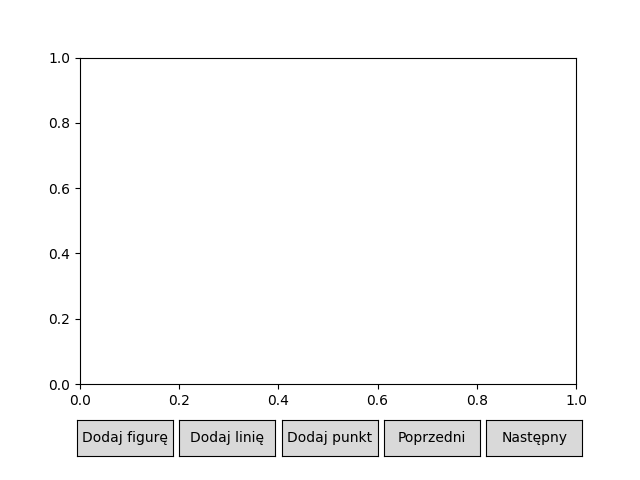

In [16]:
def emptyCanvas(xLim: int=10, yLim: int=10) -> Plot:
    return Plot(points=[PointsCollection([(xLim, yLim), (0, 0)], color='white')])
polygonPlot = emptyCanvas()
polygonPlot.draw()

Po narysowaniu wielokąta ten może zostać zapisany do pliku json.

In [17]:
writeToFile("samplePolygon.json", Plot(scenes=[polygonPlot.get_added_elements()]))


Aby uzyskać informację o krawędziach narysowanego wielokąta można użyć funkcji getEdgesFromScene() - w przypadku, gdy wielokąt został wczytany z zewnętrznego pliku do zmiennej, albo getEdgesAddedToPlot(), gdy chcemy otrzymać krawędzie narysowane na wykresie. Funkcje zwracają pierwszy z wielokątów dodanych do obrazu.

In [18]:
def getEdgesFromScene(polygon: Plot) -> list:
    return polygon.scenes[0].lines[0].lines

# pol = readFromFile("samplePolygon.json")
# pol.draw()
# edges = getEdgesFromScene(pol)

def getEdgesAddedToPlot(polygon: Plot) -> list:
    return polygon.get_added_elements().lines[0].lines

edges2 = getEdgesAddedToPlot(polygonPlot)


Lista krawędzi nie jest wygodną implementacją, dlatego zamieniam ją na listę wierzchołków, w której kolejność wierzchołków pozwala ustalić ostateczny wygląd wielokątu.

In [19]:
def convertToPoints(edges: list) -> list:
    return [Point(tuple(el[0])) for el in edges]
pointList = convertToPoints(edges2)


Aby wyświetlić skategoryzowane punkty obiektu klasy polygon należy stworzyć obiekt klasy Plot z wywołaną metodą getPCCategorized(), która zwróci obiekt klasy PointCollection ze skategoryzowanymi punktami możliwymi do wyświetlenia.

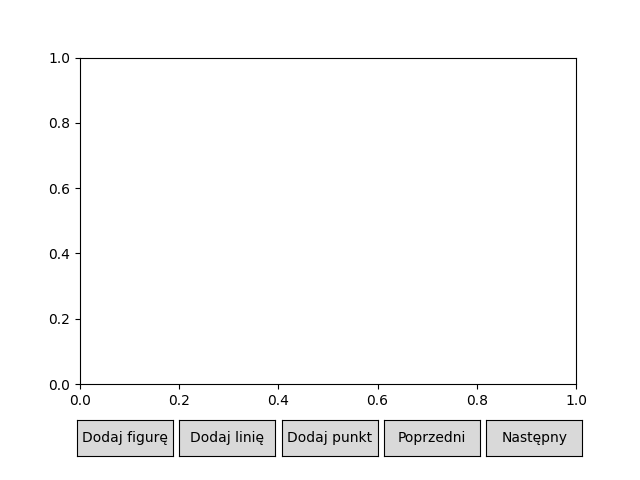

In [20]:
pointList = convertToPoints(edges2)
polygonClass = Polygon(pointList)

plotClass = Plot(points = polygonClass.getPCCategorized(),
                 lines = polygonClass.getLCPolygon())

plotClass.draw()

Algorytm triangulacji wielokąta monotonicznego

In [21]:
def isInside(a: Point, b: Point, c:Point) -> bool:
    sgn = det(a, b, c)
    if c.side == 1:
        return sgn == -1
    else:
        return sgn == 1

def triangulate(pol: Polygon) -> None:
    if not pol.isYMonotone():
        print("cannot triangulate - not Y-Monotone polygon")
        return
    s = []
    s.append(pol.vertices[pol.sortedIndexes[0]])
    s.append(pol.vertices[pol.sortedIndexes[1]])
    for i in range(2, len(pol.vertices)):
        v = pol.vertices[pol.sortedIndexes[i]]
        if v.side != s[-1].side:
            for _ in range(len(s)):
                u = s.pop()
                if len(s) > 0:
                    pol.addTriangle(s[-1], u, v)
            s.append(pol.vertices[pol.sortedIndexes[i-1]])
            s.append(v)
        else:
            u = s.pop()
            while len(s) > 0 and isInside(s[-1], u, v):
                pol.addTriangle(s[-1], u, v)
                u = s.pop()
            s.append(u)
            s.append(v)


Do użycia algorytmu należy mieć stworzony obiekt klasy Polygon, na którym zostanie wywołana funkcja triangulate. Do wyświetlenia podstawowej siatki wystarczy stworzyć obiekt klasy Plot z zadanym parametrem lines = polygon.getLCTriangulation()

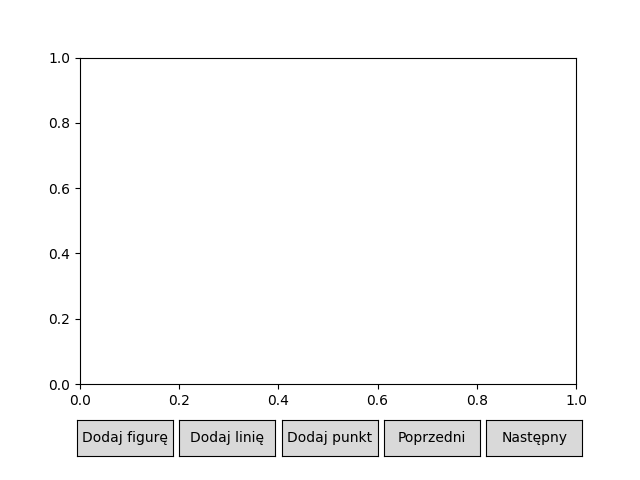

In [22]:
givenPolygon = Polygon(convertToPoints(getEdgesAddedToPlot(polygonPlot)))

triangulate(givenPolygon)
showTriangulation = Plot(points = givenPolygon.getPC(),
                 lines = givenPolygon.getLCTriangulation())
showTriangulation.draw()


Do wyświetlenia kolejnych kroków działania algorytmu stworzona została osobna funkcja triangulateWithAnimation()

In [23]:
def triangulateWithAnimation(pol: Polygon) -> None:
    if not pol.isYMonotone():
        print("cannot triangulate - not Y-Monotone polygon")
        return
    pol.addSceneToAnimation()
    s = []
    s.append(pol.vertices[pol.sortedIndexes[0]])
    s[-1].animStat = AnimStatus.ONSTACK
    pol.addSceneToAnimation()
    s.append(pol.vertices[pol.sortedIndexes[1]])
    s[-1].animStat = AnimStatus.ONSTACK
    pol.addSceneToAnimation()
    for i in range(2, len(pol.vertices)):
        v = pol.vertices[pol.sortedIndexes[i]]
        v.animStat = AnimStatus.PROCESSING
        pol.addSceneToAnimation()
        if v.side != s[-1].side:
            for _ in range(len(s)):
                u = s.pop()
                u.animStat = AnimStatus.PROCESSED
                pol.addSceneToAnimation()
                if len(s) > 0:
                    pol.addTriangle(s[-1], u, v)
                    pol.addSceneToAnimation()
            s.append(pol.vertices[pol.sortedIndexes[i-1]])
            s[-1].animStat = AnimStatus.ONSTACK
            pol.addSceneToAnimation()
            s.append(pol.vertices[pol.sortedIndexes[i]])
            s[-1].animStat = AnimStatus.ONSTACK
            pol.addSceneToAnimation()
        else:
            u = s.pop()
            u.animStat = AnimStatus.PROCESSED
            pol.addSceneToAnimation()
            if len(s) > 0 and not isInside(s[-1], u, v):
                pol.addSceneToAnimation((s[-1], u, v))
            while len(s) > 0 and isInside(s[-1], u, v):
                pol.addTriangle(s[-1], u, v)
                pol.addSceneToAnimation()
                u = s.pop()
                u.animStat = AnimStatus.PROCESSED
                pol.addSceneToAnimation()
                if len(s) > 0 and not isInside(s[-1], u, v):
                    pol.addSceneToAnimation((s[-1], u, v))
            s.append(u)
            u.animStat = AnimStatus.ONSTACK
            pol.addSceneToAnimation()
            s.append(v)
            v.animStat = AnimStatus.ONSTACK
            pol.addSceneToAnimation()
    s[-1].animStat = AnimStatus.PROCESSED
    s[-2].animStat = AnimStatus.PROCESSED
    pol.addSceneToAnimation()

Aby otrzymać animację należy postąpić analogicznie jak z wyświetlaniem samej triangulacji. Na obiekcie klasy Polygon należy wywołać odpowiednią funkcję i stworzyć obiekt klasy Plot z parametrem scenes=polygon.getAnimation(), a następnie wyświetlić ten obiekt. 

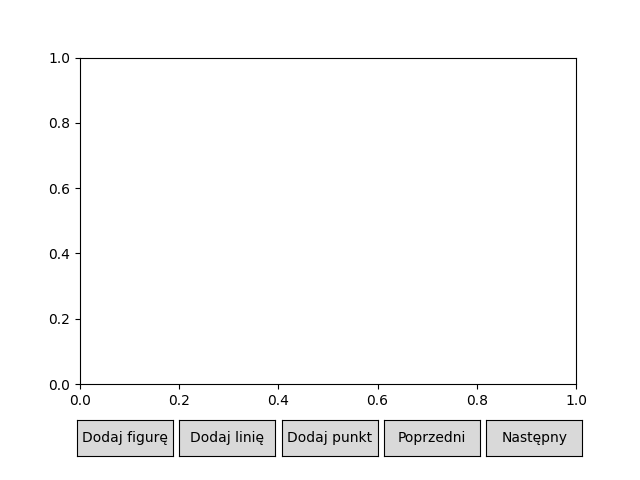

In [24]:
givenPolygon = Polygon(convertToPoints(getEdgesAddedToPlot(polygonPlot)))
triangulateWithAnimation(givenPolygon)
animation = Plot(scenes=givenPolygon.getAnimation())
animation.draw()

## Przykładowe użycia

W poniższej komórce można narysować swój wielokąt 

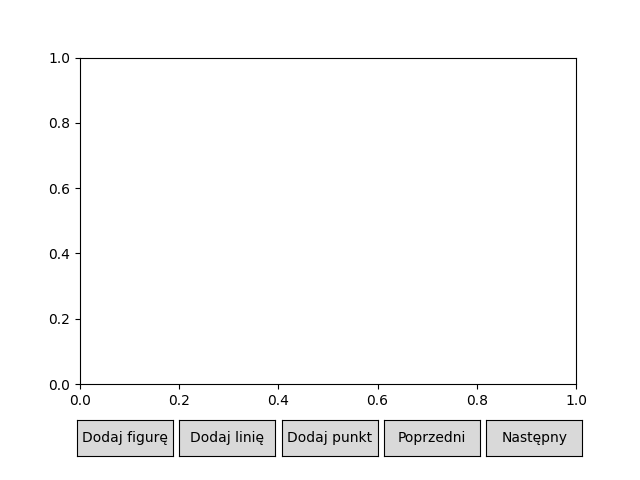

In [25]:
drawHere = emptyCanvas()
drawHere.draw()

Poniższy kod wyświetli kategoryzację wierzchołków (niezależnie od monotoniczności wielokąta).
Legenda kolorów wierzchołków:
Zielony - początkowy,
Czerwony - końcowy,
Niebieski - łączący,
Szary - dzielący,
Czarny - prawidłowy.

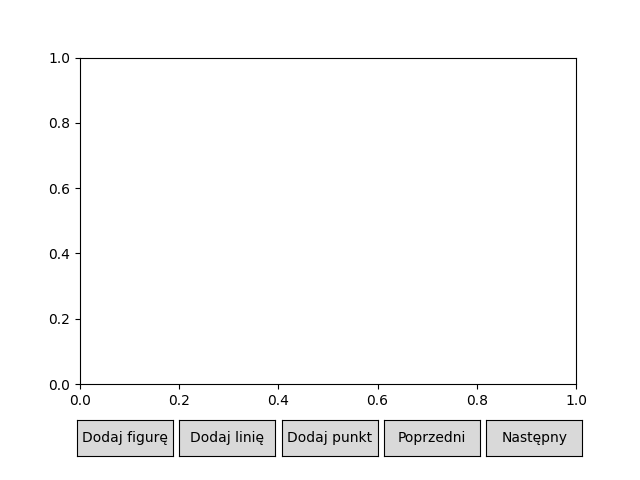

In [26]:
polygon = Polygon(convertToPoints(getEdgesAddedToPlot(drawHere)))
Plot(points = polygon.getPCCategorized(), lines=polygon.getLCPolygon()).draw()

Poniższy kod wyświetli triangulację narysowanego wielokąta Y-monotonicznego.

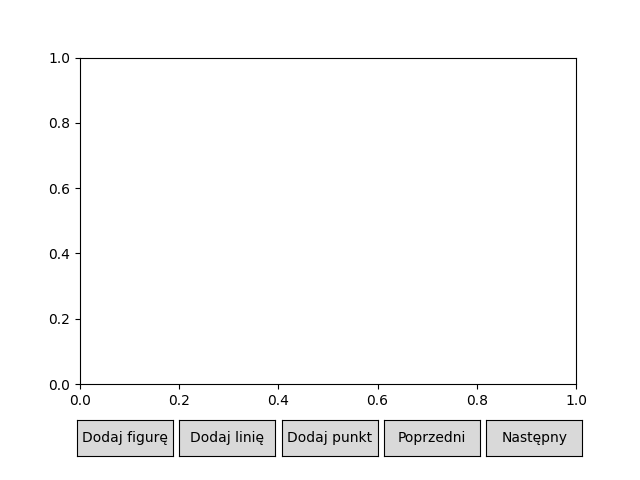

In [27]:
polygon = Polygon(convertToPoints(getEdgesAddedToPlot(drawHere)))
triangulate(polygon)
Plot(points = polygon.getPC(), lines=polygon.getLCPolygon()+polygon.getLCTriangulation()).draw()

Poniższy kod wyświetli triangulację krok po kroku.

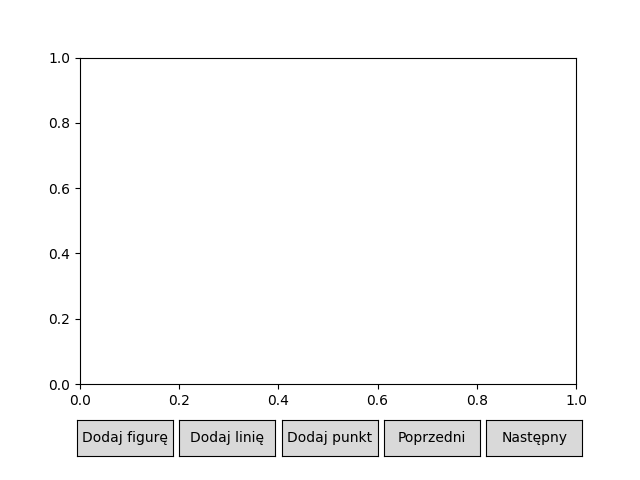

In [28]:
polygon = Polygon(convertToPoints(getEdgesAddedToPlot(drawHere)))
triangulateWithAnimation(polygon)
pl = Plot(scenes=polygon.getAnimation())
pl.draw()